In [1]:
import os
import pathlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import splitfolders
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import mixed_precision
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Activation, Input, Average
from tensorflow.keras.applications import DenseNet121, ResNet50, EfficientNetB0
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
import tensorflow as tf

# Enable memory growth for GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [3]:
splitfolders.ratio(
    r"C:\Users\A D SARNITHA\OneDrive\Documents\Project\DR detection\Diabeties-Detection-CNN-main\dataset",
    output="Output",
    seed=1337,
    ratio=(.8, 0.0,.2),  
    group_prefix=None,
    move=False
)

print("Train directory:", os.path.exists("Output/train"))
print("Test directory:", os.path.exists("Output/test"))

Copying files: 2900 files [00:12, 224.28 files/s]


Train directory: True
Test directory: True


In [4]:
# Directories
data_dir = pathlib.Path('Output/')
train_dir = 'Output/train'
test_dir = 'Output/test'

In [5]:
# Data Generators
train_datagen = ImageDataGenerator(rescale=1/255.0)
test_datagen = ImageDataGenerator(rescale=1/255.0)


In [6]:
train_data = train_datagen.flow_from_directory(train_dir, batch_size=128, target_size=(224, 224), class_mode='categorical', shuffle=True)
test_data = test_datagen.flow_from_directory(test_dir, batch_size=128, target_size=(224, 224), class_mode='categorical', shuffle=False)


Found 2642 images belonging to 5 classes.
Found 645 images belonging to 5 classes.


In [7]:
# Load Base Models
base_model1 = DenseNet121(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model2 = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model3 = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

for model in [base_model1, base_model2, base_model3]:
    model.trainable = False


In [8]:
# Model Inputs
inputs = Input(shape=(224, 224, 3))

In [9]:
# Feature Extraction
x1 = base_model1(inputs, training=False)
x1 = GlobalAveragePooling2D()(x1)
x1 = Dense(1024, activation='relu')(x1)  # Align to 1024

x2 = base_model2(inputs, training=False)
x2 = GlobalAveragePooling2D()(x2)
x2 = Dense(1024, activation='relu')(x2)  # Align to 1024

x3 = base_model3(inputs, training=False)
x3 = GlobalAveragePooling2D()(x3)
x3 = Dense(1024, activation='relu')(x3)  # Align to 1024

# Merge Outputs
merged = Average()([x1, x2, x3])
dropout = Dropout(0.25)(merged)
predictions = Dense(5, activation='softmax')(dropout)


In [10]:
# Define Model
ensemble_model = Model(inputs, predictions)
ensemble_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the Model
history = ensemble_model.fit(train_data, epochs=20)

C:\Users\A D SARNITHA\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 444s 18s/step - accuracy: 0.2957 - loss: 1.7699
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 365s 17s/step - accuracy: 0.4880 - loss: 1.1627
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 363s 17s/step - accuracy: 0.4854 - loss: 1.1396
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 363s 17s/step - accuracy: 0.5335 - loss: 1.0528
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 365s 17s/step - accuracy: 0.5251 - loss: 1.0413
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 365s 17s/step - accuracy: 0.5559 - loss: 1.0060
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 363s 17s/step - accuracy: 0.5409 - loss: 1.0228
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 364s 17s/step - accuracy: 0.5517 - loss: 1.0063
Epoch 9/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 366s 17s/step - accuracy: 0.5557 - loss: 0.9871
Epoch 10/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 372s 18s/step - accuracy: 0.5703 - loss: 0.9500
Epoch 11/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 376s 18s/step - accuracy: 0.5793 - loss: 0.9355
Epoch 12/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 370s 18s/step

In [11]:
test_loss, test_acc = ensemble_model.evaluate(test_data)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

6/6 ━━━━━━━━━━━━━━━━━━━━ 98s 13s/step - accuracy: 0.6275 - loss: 0.9078
Test Accuracy: 58.91%


In [13]:
# Evaluate on Test Data
test_pred = ensemble_model.predict(test_data)
test_pred_labels = np.argmax(test_pred, axis=1)

# Print Classification Report
true_labels = test_data.classes
print(classification_report(true_labels, test_pred_labels))


6/6 ━━━━━━━━━━━━━━━━━━━━ 122s 17s/step
              precision    recall  f1-score   support

           0       0.45      0.80      0.58       126
           1       0.43      0.38      0.40       119
           2       0.73      0.48      0.58        73
           3       0.73      0.94      0.82       119
           4       0.75      0.42      0.54       208

    accuracy                           0.59       645
   macro avg       0.62      0.60      0.58       645
weighted avg       0.63      0.59      0.58       645



In [14]:
# Save Model
ensemble_model.save('ensemble_model.h5',compile=False)


In [15]:
# Load and Predict on a New Image
def predict_image(image_path, model):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = np.array(img) / 255.0
    img_array = img_array.reshape(1, 224, 224, 3)
    
    label = model.predict(img_array)
    class_names = ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']
    predicted_class_index = np.argmax(label)
    predicted_class = class_names[predicted_class_index]
    
    plt.imshow(img)
    plt.title(predicted_class)
    plt.axis('off')
    plt.show()
    
    return predicted_class

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


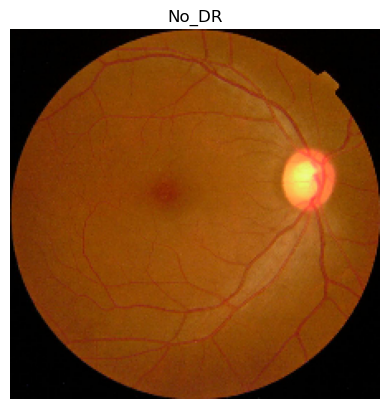

Predicted Class: No_DR


In [22]:
# Example Usage
model = load_model('ensemble_model.h5')
image_path = r"C:\Users\A D SARNITHA\OneDrive\Documents\Project\DR detection\Diabeties-Detection-CNN-main\Output\test\No_DR\1b862fb6f65d.png"
predicted_class = predict_image(image_path, model)
print("Predicted Class:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


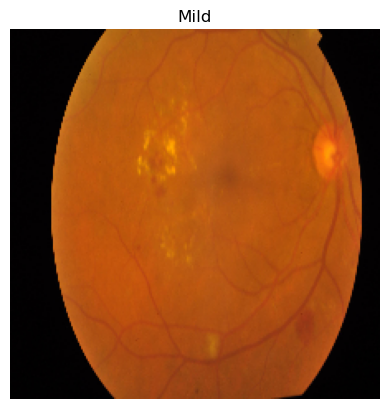

Predicted Class: Mild


In [23]:
# Example Usage
model = load_model('ensemble_model.h5')
image_path = r"C:\Users\A D SARNITHA\OneDrive\Documents\Project\DR detection\Diabeties-Detection-CNN-main\Output\test\Mild\1bea04b2bb2d.png"  
predicted_class = predict_image(image_path, model)
print("Predicted Class:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


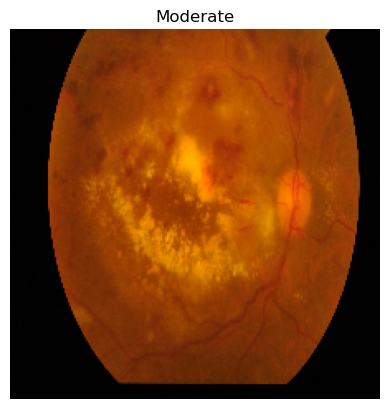

Predicted Class: Moderate


In [24]:
# Example Usage
model = load_model('ensemble_model.h5')
image_path = r"C:\Users\A D SARNITHA\OneDrive\Documents\Project\DR detection\Diabeties-Detection-CNN-main\Output\test\Moderate\498f143c0374.png"
predicted_class = predict_image(image_path, model)
print("Predicted Class:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


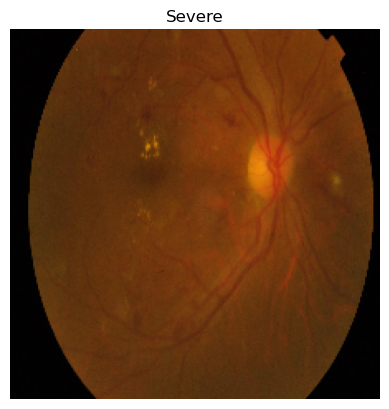

Predicted Class: Severe


In [27]:
# Example Usage
model = load_model('ensemble_model.h5')
image_path = r"C:\Users\A D SARNITHA\OneDrive\Documents\Project\DR detection\Diabeties-Detection-CNN-main\Output\test\Severe\5ed6dc419e4d.png"
predicted_class = predict_image(image_path, model)
print("Predicted Class:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


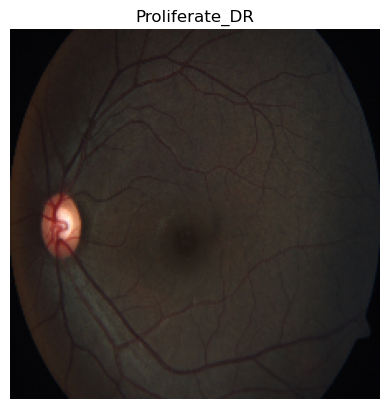

Predicted Class: Proliferate_DR


In [26]:
# Example Usage
model = load_model('ensemble_model.h5')
image_path = r"C:\Users\A D SARNITHA\OneDrive\Documents\Project\DR detection\Diabeties-Detection-CNN-main\Output\test\Proliferate_DR\1e036f2e7095.png"
predicted_class = predict_image(image_path, model)
print("Predicted Class:", predicted_class)
